# Big Data in Finance: Part II (Lecture 1) <BR><BR> Lecture Notes 3: CRSP 
    
**Instructor** <BR>
Lira Mota, lmota20@gsb.columbia.edu
    
**TA's:** <BR>
Pu He, phe19@gsb.columbia.edu <BR> Daheng Yang, dyang22@gsb.columbia.edu

**Objective:** <BR><BR> Create one data frame with the following variables:
1. Stock exchange code
2. Security code 
3. Stock monthly returns
4. Market Equity Value (AMT*PRC)
5. Risk Free Rate
    
-----------
Add variables:
1. Rankyear - Fama and French yearly rebalancing schedule
2. Returns adjusted for delisting
3. ME by PERMCO
4. ME lag (used for portfolios weights)
5. Cumulative past 11 months returns (used to calculate momentum portfolios)

## Set Up

In [1]:
%matplotlib inline 

#%% Packages 
import wrds
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

import time
from time import strptime, strftime

# Setups
pd.set_option("display.max_rows", 100) # max number or rows to be displayed 

In [2]:
#%% Set WRDS Connection
db = wrds.Connection(wrds_username='lmota') # make sure to configure wrds connector before hand.

Loading library list...
Done


## How is the CRSP data organized?

### All tables in CRSPQ

In [3]:
crsp_tables = db.list_tables(library="crspq") # compd: Compustat daily update
pd.DataFrame({'tables':crsp_tables}) # Transform libs to a Pandas data frame to have a better display.

,tables
0,ccm_qvards
1,sechist
2,comphist
3,compmaster
4,ccmxpf_linktable
5,ccmxpf_lnkrng
6,ccmxpf_lnkused
7,ccmxpf_lnkhist
8,ccm_lookup
9,comphead


We are going to focus on three tables:

1. MSF
2. MSE
3. MCTI

### Primary Keys (PK)

* Company identifier: PERMCO
* Security identifier: PERMNO
* Date: monthly or daily

### Extra Identifiers: names table

In [4]:
db.describe_table(library="crspq", table="stocknames")

Approximately 61235 rows in crspq.stocknames.


,name,nullable,type
0,permno,True,DOUBLE PRECISION
1,permco,True,DOUBLE PRECISION
2,namedt,True,DATE
3,nameenddt,True,DATE
4,cusip,True,VARCHAR(8)
5,ncusip,True,VARCHAR(8)
6,ticker,True,VARCHAR(5)
7,comnam,True,VARCHAR(32)
8,hexcd,True,DOUBLE PRECISION
9,exchcd,True,DOUBLE PRECISION


## The Stock/Securities Files Table (sfm or sfd)

### All Variables in SFM

In [5]:
db.describe_table(library="crspq", table="msf")

Approximately 4508120 rows in crspq.msf.


,name,nullable,type
0,cusip,True,VARCHAR(8)
1,permno,True,DOUBLE PRECISION
2,permco,True,DOUBLE PRECISION
3,issuno,True,DOUBLE PRECISION
4,hexcd,True,DOUBLE PRECISION
5,hsiccd,True,DOUBLE PRECISION
6,date,True,DATE
7,bidlo,True,DOUBLE PRECISION
8,askhi,True,DOUBLE PRECISION
9,prc,True,DOUBLE PRECISION


### Variables of interest

1. Identifiers: date, permno, permco
2. Price: prc
3. Return: ret
4. Return Ex-dividend: retx
5. Factor to adjust prices and shares outstading: 'cfacpr'/'cfacshr'


Where to find variable definitions? [WRDS website](https://wrds-www.wharton.upenn.edu/pages/support/manuals-and-overviews/crsp/stocks-and-indices/overview-crsp-us-stock-database/?_ga=2.175371626.977702200.1550764493-1500651139.1501534854#database-notes).


In [6]:
sfvars = ['prc','vol','ret', 'retx','cfacpr','cfacshr']
query = """SELECT date, permno, permco, {} 
           FROM crspq.msf
           WHERE date>='2000-01-01'""".format(', '.join(sfvars))
print(query)

SELECT date, permno, permco, prc, vol, ret, retx, cfacpr, cfacshr 
           FROM crspq.msf
           WHERE date>='2000-01-01'


In [7]:
msf_data = db.raw_sql(query, date_cols=['date'])
del(sfvars, query) 

**Look at the data =)**

In [8]:
msf_data.head()

,date,permno,permco,prc,vol,ret,retx,cfacpr,cfacshr
0,2000-01-31,10001.0,7953.0,8.12500,403.0,-0.044118,-0.044118,1.5,1.5
1,2000-02-29,10001.0,7953.0,8.25000,222.0,0.015385,0.015385,1.5,1.5
2,2000-03-31,10001.0,7953.0,-8.00000,723.0,-0.015758,-0.030303,1.5,1.5
3,2000-04-28,10001.0,7953.0,-8.09375,263.0,0.011719,0.011719,1.5,1.5
4,2000-05-31,10001.0,7953.0,-7.90625,221.0,-0.023166,-0.023166,1.5,1.5


In [9]:
# Check if PK 
msf_data.duplicated(subset=['permno', 'date']).sum()

0

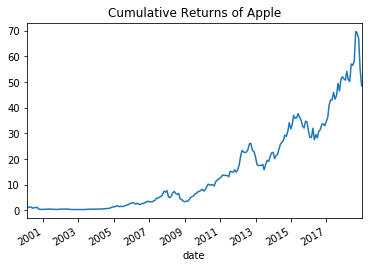

In [10]:
# Cumulative returns of Apple 
((1+msf_data[msf_data.permno==14593].set_index(['date']).ret).cumprod()).plot(title='Cumulative Returns of Apple')

## The Stock/Security Events (mse, mseall, dse, dseall) 

### All variables in MSEALL

In [11]:
db.describe_table(library="crspq", table="mseall")

Approximately 3139880 rows in crspq.mseall.


,name,nullable,type
0,date,True,DATE
1,comnam,True,VARCHAR(32)
2,cusip,True,VARCHAR(8)
3,dclrdt,True,DATE
4,dlamt,True,DOUBLE PRECISION
5,dlpdt,True,DATE
6,dlstcd,True,DOUBLE PRECISION
7,hsiccd,True,DOUBLE PRECISION
8,issuno,True,DOUBLE PRECISION
9,ncusip,True,VARCHAR(8)


### Variables of Interest 
1. Delisting returns: dlret, dlretx
2. Exchange code: exchcd (NYSE=1, AMEX=2, Nasdaq=3)
3. Share code: shrcd 
4. Industry classifications: siccd, naics
5. Stock Ticker


In [12]:
msevars = ['dlret', 'dlretx', 'exchcd','naics', 'ncusip', 'shrcd', 'shrout', 
           'siccd','ticker', 'distcd','facpr','facshr']
query = """SELECT date, permno, permco, {} 
           FROM crspq.mseall
           WHERE date>='2000-01-01'""".format(', '.join(msevars))
print(query)

SELECT date, permno, permco, dlret, dlretx, exchcd, naics, ncusip, shrcd, shrout, siccd, ticker, distcd, facpr, facshr 
           FROM crspq.mseall
           WHERE date>='2000-01-01'


In [13]:
mse_data = db.raw_sql(query, date_cols=['date'])
del(msevars, query) 

**Look at the data...**

In [14]:
mse_data[mse_data.permno==14593] 

,date,permno,permco,dlret,dlretx,exchcd,naics,ncusip,shrcd,shrout,siccd,ticker,distcd,facpr,facshr
177677,2000-01-31,14593.0,7.0,NaN,NaN,3.0,None,03783310,11.0,161159.0,3573.0,AAPL,NaN,NaN,NaN
177678,2000-02-29,14593.0,7.0,NaN,NaN,3.0,None,03783310,11.0,161159.0,3573.0,AAPL,NaN,NaN,NaN
177679,2000-03-31,14593.0,7.0,NaN,NaN,3.0,None,03783310,11.0,162680.0,3573.0,AAPL,NaN,NaN,NaN
177680,2000-04-28,14593.0,7.0,NaN,NaN,3.0,None,03783310,11.0,162680.0,3573.0,AAPL,NaN,NaN,NaN
177681,2000-05-31,14593.0,7.0,NaN,NaN,3.0,None,03783310,11.0,162744.0,3573.0,AAPL,NaN,NaN,NaN
177682,2000-06-30,14593.0,7.0,NaN,NaN,3.0,None,03783310,11.0,324826.0,3573.0,AAPL,5523.0,1.0,1.0
177683,2000-07-31,14593.0,7.0,NaN,NaN,3.0,None,03783310,11.0,324969.0,3573.0,AAPL,NaN,NaN,NaN
177684,2000-08-31,14593.0,7.0,NaN,NaN,3.0,None,03783310,11.0,324969.0,3573.0,AAPL,NaN,NaN,NaN
177685,2000-09-29,14593.0,7.0,NaN,NaN,3.0,None,03783310,11.0,335677.0,3573.0,AAPL,NaN,NaN,NaN
177686,2000-10-31,14593.0,7.0,NaN,NaN,3.0,None,03783310,11.0,335766.0,3573.0,AAPL,NaN,NaN,NaN


### Check Primary Key

In [15]:
# Check PK
mse_data.duplicated(subset=['date','permno']).sum()

18035

In [16]:
# Check Duplicates
mse_data[mse_data.duplicated(subset=['date','permno'])]

,date,permno,permco,dlret,dlretx,exchcd,naics,ncusip,shrcd,shrout,siccd,ticker,distcd,facpr,facshr
98,2008-02-29,10001.0,7953.0,NaN,NaN,3.0,221210,29274A20,11.0,4345.0,4920.0,EWST,1222.0,0.000000,0.000000
697,2017-01-31,10025.0,7975.0,-0.050551,-0.050551,3.0,326113,00103110,11.0,5114.0,3081.0,AEPI,3723.0,-1.000000,-1.000000
1650,2005-06-30,10044.0,7992.0,NaN,NaN,3.0,311330,77467840,11.0,6187.0,2060.0,RMCF,5523.0,0.333333,0.333333
2091,2000-02-29,10065.0,20023.0,NaN,NaN,1.0,None,00621210,14.0,53453.0,6723.0,ADX,2216.0,0.000000,0.000000
2101,2000-11-30,10065.0,20023.0,NaN,NaN,1.0,None,00621210,14.0,79186.0,6723.0,ADX,2216.0,0.000000,0.000000
2105,2001-02-28,10065.0,20023.0,NaN,NaN,1.0,None,00621210,14.0,81958.0,6723.0,ADX,2216.0,0.000000,0.000000
2115,2001-11-30,10065.0,20023.0,NaN,NaN,1.0,None,00621210,14.0,81622.0,6726.0,ADX,2216.0,0.000000,0.000000
2119,2002-02-28,10065.0,20023.0,NaN,NaN,1.0,None,00621210,14.0,85171.0,6726.0,ADX,2216.0,0.000000,0.000000
2129,2002-11-29,10065.0,20023.0,NaN,NaN,1.0,None,00621210,14.0,82788.0,6726.0,ADX,2216.0,0.000000,0.000000
2133,2003-02-28,10065.0,20023.0,NaN,NaN,1.0,None,00621210,14.0,84083.0,6726.0,ADX,2216.0,0.000000,0.000000


In [17]:
mse_data[(mse_data.permno==10001)&(mse_data.date.dt.year>=2008)] 

,date,permno,permco,dlret,dlretx,exchcd,naics,ncusip,shrcd,shrout,siccd,ticker,distcd,facpr,facshr
96,2008-01-31,10001.0,7953.0,NaN,NaN,3.0,221210,29274A10,11.0,2875.0,4920.0,EWST,1222.0,0.0,0.0
97,2008-02-29,10001.0,7953.0,NaN,NaN,3.0,221210,29274A20,11.0,4345.0,4920.0,EWST,5523.0,0.5,0.5
98,2008-02-29,10001.0,7953.0,NaN,NaN,3.0,221210,29274A20,11.0,4345.0,4920.0,EWST,1222.0,0.0,0.0
99,2008-03-31,10001.0,7953.0,NaN,NaN,3.0,221210,29274A20,11.0,4347.0,4920.0,EWST,1222.0,0.0,0.0
100,2008-04-30,10001.0,7953.0,NaN,NaN,3.0,221210,29274A20,11.0,4347.0,4920.0,EWST,1222.0,0.0,0.0
101,2008-05-30,10001.0,7953.0,NaN,NaN,3.0,221210,29274A20,11.0,4347.0,4920.0,EWST,1222.0,0.0,0.0
102,2008-06-30,10001.0,7953.0,NaN,NaN,3.0,221210,29274A20,11.0,4349.0,4920.0,EWST,1222.0,0.0,0.0
103,2008-07-31,10001.0,7953.0,NaN,NaN,3.0,221210,29274A20,11.0,4349.0,4920.0,EWST,1222.0,0.0,0.0
104,2008-08-29,10001.0,7953.0,NaN,NaN,3.0,221210,29274A20,11.0,4349.0,4920.0,EWST,1222.0,0.0,0.0
105,2008-09-30,10001.0,7953.0,NaN,NaN,3.0,221210,29274A20,11.0,4349.0,4920.0,EWST,1222.0,0.0,0.0


In [18]:
# Redownlod without distcd 
msevars = ['dlret', 'dlretx', 'exchcd','naics', 'ncusip', 'shrcd', 'shrout', 
           'siccd','ticker']
query = """SELECT date, permno, permco, {} 
           FROM crspq.mseall
           WHERE date>='2000-01-01'""".format(', '.join(msevars))
print(query)

SELECT date, permno, permco, dlret, dlretx, exchcd, naics, ncusip, shrcd, shrout, siccd, ticker 
           FROM crspq.mseall
           WHERE date>='2000-01-01'


In [19]:
mse_data = db.raw_sql(query, date_cols=['date'])
del(msevars, query) 

In [20]:
mse_data = mse_data[~mse_data.duplicated()].copy()

In [21]:
# Check PK
mse_data.duplicated(subset=['date','permno']).sum()

0

In [22]:
mse_data.head()

,date,permno,permco,dlret,dlretx,exchcd,naics,ncusip,shrcd,shrout,siccd,ticker
0,2000-01-31,10001.0,7953.0,NaN,NaN,3.0,None,29274A10,11.0,2450.0,4920.0,EWST
1,2000-02-29,10001.0,7953.0,NaN,NaN,3.0,None,29274A10,11.0,2450.0,4920.0,EWST
2,2000-03-31,10001.0,7953.0,NaN,NaN,3.0,None,29274A10,11.0,2464.0,4920.0,EWST
3,2000-04-28,10001.0,7953.0,NaN,NaN,3.0,None,29274A10,11.0,2464.0,4920.0,EWST
4,2000-05-31,10001.0,7953.0,NaN,NaN,3.0,None,29274A10,11.0,2464.0,4920.0,EWST


## Merge MSF and MSEALL

When merging mse and msf tables we should copy information from event observations to succeeding non-event observations.

Check data types: for some reason the merge does not work for PERMNO as float

In [23]:
msf_data.dtypes

date       datetime64[ns]
permno            float64
permco            float64
prc               float64
vol               float64
ret               float64
retx              float64
cfacpr            float64
cfacshr           float64
dtype: object

In [24]:
## Check data types
mse_data.dtypes       

date      datetime64[ns]
permno           float64
permco           float64
dlret            float64
dlretx           float64
exchcd           float64
naics             object
ncusip            object
shrcd            float64
shrout           float64
siccd            float64
ticker            object
dtype: object

In [25]:
# Change Permno Data Type.
msf_data['permno'] = msf_data['permno'].astype('int')
mse_data['permno'] = mse_data['permno'].astype('int')

In [26]:
msf_data.sort_values(['date', 'permno'], inplace=True)
mse_data.sort_values(['date', 'permno'], inplace=True)

**Merge tables with following logic:**
* For each msf observation, merge most recent mseall observation with same permno,
* If particular permno-date combination does not exist in msf but does in sseall, include that observation.
 
**How to do this?** Pandas is powerful! 

In [27]:
from IPython.display import IFrame
IFrame('https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge_asof.html', width=900, height=400)

In [28]:
crsp = pd.merge_asof(msf_data, mse_data, on='date', by=['permno','permco'], 
                     direction='backward')

In [29]:
crsp.columns

Index(['date', 'permno', 'permco', 'prc', 'vol', 'ret', 'retx', 'cfacpr',
       'cfacshr', 'dlret', 'dlretx', 'exchcd', 'naics', 'ncusip', 'shrcd',
       'shrout', 'siccd', 'ticker'],
      dtype='object')

In [30]:
crsp.head()

,date,permno,permco,prc,vol,ret,retx,cfacpr,cfacshr,dlret,dlretx,exchcd,naics,ncusip,shrcd,shrout,siccd,ticker
0,2000-01-31,10001,7953.0,8.125,403.0,-0.044118,-0.044118,1.5,1.5,NaN,NaN,3.0,None,29274A10,11.0,2450.0,4920.0,EWST
1,2000-01-31,10002,7954.0,11.875,567.0,-0.025641,-0.025641,1.0,1.0,NaN,NaN,3.0,None,83623410,11.0,7729.0,6020.0,SABC
2,2000-01-31,10009,7965.0,14.625,455.0,-0.008475,-0.008475,1.0,1.0,NaN,NaN,3.0,None,46334710,11.0,2307.0,6030.0,IROQ
3,2000-01-31,10012,7969.0,7.250,62368.0,-0.097276,-0.097276,1.0,1.0,NaN,NaN,3.0,None,24871930,10.0,19274.0,3670.0,DPAC
4,2000-01-31,10016,1728.0,17.000,10387.0,-0.099338,-0.099338,1.0,1.0,NaN,NaN,3.0,None,81002230,11.0,17869.0,3560.0,SCTT


In [31]:
# Check Primary Key
crsp.duplicated(subset=['permno','date']).sum()

0

In [32]:
# Check Apple
crsp[crsp.permno==14593].head()

,date,permno,permco,prc,vol,ret,retx,cfacpr,cfacshr,dlret,dlretx,exchcd,naics,ncusip,shrcd,shrout,siccd,ticker
577,2000-01-31,14593,7.0,103.7500,1140611.0,0.009119,0.009119,28.0,28.0,NaN,NaN,3.0,None,03783310,11.0,161159.0,3573.0,AAPL
9203,2000-02-29,14593,7.0,114.6250,663553.0,0.104819,0.104819,28.0,28.0,NaN,NaN,3.0,None,03783310,11.0,161159.0,3573.0,AAPL
17846,2000-03-31,14593,7.0,135.8125,788460.0,0.184842,0.184842,28.0,28.0,NaN,NaN,3.0,None,03783310,11.0,162680.0,3573.0,AAPL
26479,2000-04-28,14593,7.0,124.0625,783345.0,-0.086516,-0.086516,28.0,28.0,NaN,NaN,3.0,None,03783310,11.0,162680.0,3573.0,AAPL
35074,2000-05-31,14593,7.0,84.0000,886685.0,-0.322922,-0.322922,28.0,28.0,NaN,NaN,3.0,None,03783310,11.0,162744.0,3573.0,AAPL


## Calculate Variables of Interest

### Adjusted Returns

Add to the ret series the delisting returns

In [33]:
# Returns adjusted for delisting
crsp['retadj'] = ((1+crsp['ret'].fillna(0))*(1+crsp['dlret'].fillna(0))-1)
crsp.loc[crsp[['ret', 'dlret']].isnull().all(axis=1), 'retadj'] = np.nan

### Market Equity Value

#### Can prices be negative?

In [34]:
(crsp.prc<0).mean()      

0.03372451174815066

**Why Negative Prices?**<BR><BR>

* If the closing price is not available for any given period, the number in the price field is replaced with a bid/ask average. 
* Bid/ask averages have dashes placed in front of them. 
* These do not incorrectly reflect negative prices; they serve to distinguish bid/ask averages from actual closing prices. If neither the price nor bid/ask average is available, the field is set to zero.

#### Can number of shares outstanding be negative? 

In [35]:
(crsp.shrout<0).mean()

0.0

#### Create Market Equity (ME)

In [36]:
# SHROUT is the number of publicly held shares, recorded in thousands. ME will be reported in 1,000,000 ($10^6$),
# Like on Ken French's website. 
crsp['me'] = abs(crsp['prc']) * (crsp['shrout']/1000)

In [37]:
# Also, some companies have multiple shareclasses (=PERMNOs).
# To get the company ME, we need to calculate the sum of ME over all shareclasses for one company (=PERMCO).
# This is used for sorting, but not for weights.

# Create MEsum
crsp['mesum'] = crsp.groupby(['date', 'permco']).me.transform(np.sum, min_count=1)

In [38]:
# If the stock is delisted, we set ME to NaN.
crsp.loc[crsp.dlret.notnull(), 'me'] = np.nan
crsp.loc[crsp.dlret.notnull(), 'mesum'] = np.nan

#### Adjusting for Stock Splits and Other Corporate Actions

* Returns are already adjusted for splits, but prices and shares outstanding are not. 
* To adjust prices and shares outstanding, use the following use:
    * Adjusted prices = PRC / CFACPR
    * Adjusted shares = SHROUT * CFACSHR

### ME Lag

MElag is used as portfolio weights in the FF factors.

In [39]:
crsp.sort_values(['permno','date'], inplace=True)

In [40]:
crsp['melag_nt']=crsp.groupby(['permno']).me.shift(1)

In [41]:
# TODO: Check for skipping
# What to do if ME is missing?

crsp['melag'] = crsp.groupby('permno').melag_nt.fillna(method='pad')

# Fill na after delisting
#df = post_event_nan(df=df, event=df.lag_dlret.notnull(), vars=['melag'], id_vars=['permno', 'edate'])

### Rankyear

In [42]:
# Portfolios are rebalanced in the end of june
crsp['rankyear'] = crsp.date.dt.year
crsp.loc[crsp.date.dt.month <= 6, 'rankyear'] = crsp.loc[crsp.date.dt.month <= 6, 'rankyear'] - 1

## Add Risk Free

In [43]:
# Dowload the data
#%% Import Data
query = "SELECT caldt as date, t30ret as rf FROM crspq.mcti"
rf = db.raw_sql(query, date_cols=['date'])

In [44]:
rf.head()

,date,rf
0,1925-12-31,NaN
1,1926-01-30,0.002951
2,1926-02-27,0.002768
3,1926-03-31,0.002778
4,1926-04-30,0.003072


In [45]:
# Month dates: dates do not match directly to the ones in CRSP
rf['mdate'] = rf.date.dt.year*100+rf.date.dt.month

In [46]:
rf.drop(columns=['date'], inplace=True)

In [47]:
crsp['mdate']=crsp.date.dt.year*100+crsp.date.dt.month

In [48]:
crsp = pd.merge(crsp, rf, on=['mdate'])

In [49]:
crsp.rf.isnull().sum()

0

In [50]:
crsp.columns

Index(['date', 'permno', 'permco', 'prc', 'vol', 'ret', 'retx', 'cfacpr',
       'cfacshr', 'dlret', 'dlretx', 'exchcd', 'naics', 'ncusip', 'shrcd',
       'shrout', 'siccd', 'ticker', 'retadj', 'me', 'mesum', 'melag_nt',
       'melag', 'rankyear', 'mdate', 'rf'],
      dtype='object')

## Save Output

In [51]:
crsp.head()

,date,permno,permco,prc,vol,ret,retx,cfacpr,cfacshr,dlret,...,siccd,ticker,retadj,me,mesum,melag_nt,melag,rankyear,mdate,rf
0,2000-01-31,10001,7953.0,8.125,403.0,-0.044118,-0.044118,1.5,1.5,NaN,...,4920.0,EWST,-0.044118,19.906250,19.906250,NaN,NaN,1999,200001,0.004343
1,2000-01-31,10002,7954.0,11.875,567.0,-0.025641,-0.025641,1.0,1.0,NaN,...,6020.0,SABC,-0.025641,91.781875,91.781875,NaN,NaN,1999,200001,0.004343
2,2000-01-31,10009,7965.0,14.625,455.0,-0.008475,-0.008475,1.0,1.0,NaN,...,6030.0,IROQ,-0.008475,33.739875,33.739875,NaN,NaN,1999,200001,0.004343
3,2000-01-31,10012,7969.0,7.250,62368.0,-0.097276,-0.097276,1.0,1.0,NaN,...,3670.0,DPAC,-0.097276,139.736500,139.736500,NaN,NaN,1999,200001,0.004343
4,2000-01-31,10016,1728.0,17.000,10387.0,-0.099338,-0.099338,1.0,1.0,NaN,...,3560.0,SCTT,-0.099338,303.773000,303.773000,NaN,NaN,1999,200001,0.004343


In [53]:
crsp.to_pickle(path='C:/Users/lmota20/Dropbox/Columbia/BigData/class2019/Lecture_I/outputs/crsp_montly.pkl')